# Seattle City Crime Data Analysis

## 1: Introduction and Motivation

As an international student in University of Washington, I am curious about the City of Seattle and would love to explore different city areas. By learning HCDE 410 and other data science classes in the UW, I am equipped with skills to analyze datasets and generate insights from them. Since I'm concerned about the city's public safety, I want to analyze its crime data to understand frequent crime types, in order to make me educated when going to different places. Research Question 2 is inspired from my past street-walking experience, especially when I'm walking in unfamiliar areas, as I'm concerned about whether it's more likely that a person attacks me or just wants my property (no personal harm if I comply).

Since I primarily reside in University District while studying in the UW, I want to learn the crime distribution in this area through study Question 3. Before COVID-19 pandemic that moves all UW classes online, I occasionally studied in UW libraries, where I discovered posters (from UW Police department) that urge students to protect their valuable items and never leave them unattended. In addition, I occasionally saw bikes (on bike rack) with missing parts, implying that an offender stole usable parts on students' bikes. 

## 2: Background and/or Related Work

While researching the Seattle Crime overview, I found [this US News article](https://realestate.usnews.com/places/washington/seattle/crime) describing that Seattle has "a \[relatively\] lower crime rate than similarly sized metro areas"; it has a higher rate of crimes against property and a lower rate of violent crimes (against people), comparing to the national average. Also, I learned that Seattle has a record high number of murder incidents in 2020, according to this [King5 news article](https://www.king5.com/article/news/local/seattle-police-reports-49-murders-setting-pace-for-record-homicides/281-c32aa4ae-ef9c-485f-a9d8-1113b491fc9d). Within the University of Washington; UW Police websites allow students to register [bicycles](https://bikeindex.org/uw) and [electronics](http://police.uw.edu/community-engagement/loveyourstuff/ereg/), and contents in these web pages describe the prevalence of thefts on them. Hence I assume that robbery/theft are the most frequent offense in the University District. Regarding how COVID-19 Pandemic affecting crime distribution, I remembered that attacks against people increases partially due to economic depression and discrimination against east Asian people (alleged origin of COVID-19).

I have adjusted my research question 2, 3, and 4 according to my background research, as I want to use the actual crime data from Seattle Police Department to verify claims made in these articles. In addition, I can learn whether robbery/theft crimes is the most frequent offense in the University District, and whether this crime is noticeably more frequent than the second most popular crime in this UW area. All in all, I hope my final project is related to HCDE 410's lecture regarding open data science where readers can use raw data to audit claims made in analytical reports.

## 3: Research questions

1. Do certain types of crime offenses have become more popular after the onset of COVID-19 Pandemic?
2. Do crimes against a person happen more frequently than crimes against property in Seattle, generally?
3. Within the University District, what are most frequent crime offenses.
4. Does Seattle have a record high homicide crime counts in 2020?

### Hypothesis:

1. Personal assault crimes have become more popular after the onset of COVID-19 Pandemic (beginning 2020-01-01).
2. I hypothesize that crime against property happens more frequently than crimes against a person. 
3. Robbery/theft are the most frequent offenses in the University District.
4. Seattle does have a record high homicide crime count in 2020.


## 4: Data Source

**Seattle City Crime Data**

This data is provided by the City of Seattle Police Department documents city-wide crime data since 2008. It is comprehensive, including offense time, type of crime, large neighborhood district, providing me many ways to analyze the crime distribution in Seattle.

[Dataset source](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5) (Time Range: from 2008 to present)

License: Public Domain

Import necessary Python libraries for this data analysis

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

In [2]:
#ggplot2 in R is a very intuitive and easy to understand graph programming syntax (and there're just a lot of articles on ggplot due to its popularity)
#One noticeable limitation for plotnine it that it could not draw pie chart (it lacks coord_polar implementation)

#!conda install plotnine # if plotnine is not already installed
#!pip install plotnine # if plotnine is not already installed
from plotnine import * #plotnine contains ggplot function
# from plotnine.data import mpg #import ggplot's sample data (such as mpg), useful for debugging

Make an API call to download the Seattle City Crime dataset directly from the data source, and import it to this Jupyter notebook.

In [3]:
#the URL we're retrieving the data from.
api_endpoint = "https://data.seattle.gov/resource/tazs-3rd5.csv"

#the parameters we're passing to the API, to specify what subset of data we want.
api_parameters = "?$limit=10000000&" # Increase limit to 10000000, increase this number if dataset has more available rows 
api_parameters = api_parameters + "$select=offense_start_datetime,crime_against_category,offense_parent_group,offense,mcpp&" # Only select columns that I need for my data analysis

#If you don't provide a App token, then your request is rate limited (each request have no number of row limitation for this dataset)
#token.txt contains the alpha-numeric token only (no space), and we only need App token (NOT Secret Token, and NOT API key)

#check whether App token exists in ./token.txt , and read the App token if this token file exists (will simply ignore reading App token if the token.txt does not exist)
from pathlib import Path
if Path('token.txt').is_file():
    api_parameters = api_parameters + "$$app_token=" + open("token.txt", "r").readline()

print('Downloading .csv from ' + api_endpoint + api_parameters)
police_data = pd.read_csv(api_endpoint + api_parameters)

View a snippit of this police data.

In [4]:
print(police_data.head(3))

    offense_start_datetime crime_against_category    offense_parent_group  \
0  2020-02-05T10:10:00.000                SOCIETY  DRUG/NARCOTIC OFFENSES   
1  2020-02-03T08:00:00.000               PROPERTY           LARCENY-THEFT   
2  2020-02-02T20:30:00.000               PROPERTY                 ROBBERY   

                                       offense               mcpp  
0                     Drug/Narcotic Violations           MAGNOLIA  
1  Theft of Motor Vehicle Parts or Accessories  ROOSEVELT/RAVENNA  
2                                      Robbery  ROOSEVELT/RAVENNA  


## 5: Data Analysis and Methodology

### Pre-analysis data cleaning

Performing this data cleaning process (ends before Research Question 1 code) is **mandatory**, as data analysis code for all research questions depend on the cleaned dataset generated in this sub-section.

First, I will convert date string (from all four datasets) to Python datetime object so we can parse and compare dates more efficiently.

Also, I decide to remove `offense_start_datetime` before 2008-01-01, as the website stated that only data that's recorded on and after 2008 is present in dataset. Since crimes happened earlier than 2008 may be entered to this dataset, such number of crimes may be noticeably less than actual number of incidents, which would make my analysis (on crime incidents happened before 2008) biased. In fact, we only remove 2644 cases dated before 2008-01-01 (904314 crimes in the entire dataset, minus 901670 crimes that will be used in this project, calculated on 2021-05-27).

In [5]:
# Drop mili-seconds due to Python's Date format does not recognize 3-digit mili-second (it only recognize micro-second)
police_data['offense_start_date_cleaned'] = pd.to_datetime(police_data['offense_start_datetime'], format='%Y-%m-%dT%H:%M:%S') 

# Drop offense_start_datetime before 2008-01-01
police_data_cleaned = police_data[police_data['offense_start_date_cleaned'] >= datetime.strptime('2008-01-01', '%Y-%m-%d')]

# Drop pre-parsed date time column
police_data_cleaned = police_data_cleaned.drop(columns=['offense_start_datetime'])

print(police_data_cleaned.head(3))

  crime_against_category    offense_parent_group  \
0                SOCIETY  DRUG/NARCOTIC OFFENSES   
1               PROPERTY           LARCENY-THEFT   
2               PROPERTY                 ROBBERY   

                                       offense               mcpp  \
0                     Drug/Narcotic Violations           MAGNOLIA   
1  Theft of Motor Vehicle Parts or Accessories  ROOSEVELT/RAVENNA   
2                                      Robbery  ROOSEVELT/RAVENNA   

  offense_start_date_cleaned  
0        2020-02-05 10:10:00  
1        2020-02-03 08:00:00  
2        2020-02-02 20:30:00  


Below is a helper function that moves a specific column (of a dataframe) to the first column (existing columns will shift 1 place to the right). Having this function is useful to organize dataframe columns that're newly created to the first column, so that generated .csv files is clean.

In [6]:
# data_frame is a reference to the data frame object; col_name is a string that describe the column name (on the header)
def move_df_col_to_first(data_frame, col_name):
    first_col = data_frame.pop(col_name)
    data_frame.insert(0, col_name, first_col)

### Research Question 1: increased crime type after the onset of COVID-19 Pandemic

To determine whether certain types of crimes will become more popular after the onset of COVID-19 Pandemic, I first tally the monthly total of every crime type from 2019-01-01 to 2020-12-31. Then, I will make a time series graph of all crime types to visually inspect the growing trend of certain crimes after 2020-01-01.

In this analysis, I decide to use `offense_parent_group` instead of a more detailed `offense`, as the number of unique `offense` is more than the capacity limit of a presentable time-series graph (for aesthetic purposes).

In [7]:
# Select police data between 2019-01-01 and 2020-12-31
police_data_COVID = police_data_cleaned[(police_data_cleaned['offense_start_date_cleaned'] >= datetime.strptime('2019-01-01', '%Y-%m-%d')) & (police_data_cleaned['offense_start_date_cleaned'] <= datetime.strptime('2020-12-31', '%Y-%m-%d'))]

# Remove crime_against_category, mcpp, and offense columns that are not needed for 5-2 analysis
police_data_COVID = police_data_COVID.drop(columns=['crime_against_category', 'mcpp', 'offense'])

Create a dataframe that holds the monthly total of all crime offenses types.

In [8]:
# Create zero-filled dataframe that holds the count of each offense_parent_group
index = pd.Series(pd.date_range(datetime.strptime('2019-01', '%Y-%m'), datetime.strptime('2021-01', '%Y-%m'), freq='M'))
index = index.dt.strftime('%Y-%m')

# Use unique value of offense_parent_group (in police data) as column header
columns = police_data_COVID['offense_parent_group'].unique()
 
COVID_offense_tally = pd.DataFrame(index=index, columns=columns)
COVID_offense_tally = COVID_offense_tally.fillna(0)

# Using code above, the data frame's index is the month; hence we need to create another month columns (whose values are year and month only)
COVID_offense_tally['Month'] = COVID_offense_tally.index
COVID_offense_tally['Month'] = COVID_offense_tally['Month'].astype('string')

Tally the number of monthly crime offenses by `offense_parent_group`, and export the count to `Question 1 out.csv`.

In [9]:
for index, row in police_data_COVID.iterrows():
    date = row['offense_start_date_cleaned']
    one_offense = row['offense_parent_group']
    month_string = date.strftime("%Y-%m")
    #print(month_string + ' ' + one_offense)
    COVID_offense_tally.loc[COVID_offense_tally['Month'] == month_string, one_offense] += 1

move_df_col_to_first(COVID_offense_tally, 'Month')
        
#print('Now printing the monthly offense tally')
print(COVID_offense_tally.head(3))

# Make a .csv file so end users can use a software of their choice to produce different plots.
COVID_offense_tally.to_csv('Question 1 out.csv', index=False)  

           Month  DRUG/NARCOTIC OFFENSES  LARCENY-THEFT  ROBBERY  \
2019-01  2019-01                     189           2161      135   
2019-02  2019-02                     137           1621      112   
2019-03  2019-03                     153           2123      125   

         DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY  \
2019-01                                       541   
2019-02                                       369   
2019-03                                       509   

         DRIVING UNDER THE INFLUENCE  FRAUD OFFENSES  KIDNAPPING/ABDUCTION  \
2019-01                          127             341                     5   
2019-02                          108             270                     8   
2019-03                          123             265                     9   

         COUNTERFEITING/FORGERY  PORNOGRAPHY/OBSCENE MATERIAL  ...  \
2019-01                      39                             4  ...   
2019-02                      19                             2

Convert `COVID_offense_tally` to long-format to assist plotting.

In [10]:
COVID_offense_tally_long = pd.melt(frame=COVID_offense_tally, id_vars=['Month'], var_name="Offense Type", value_name="Monthly Count")
COVID_offense_tally_long['Month']= pd.to_datetime(COVID_offense_tally_long['Month'], format='%Y-%m')
#print(COVID_offense_tally_long)

Plot a time series graph denoting monthly total count of each offense.

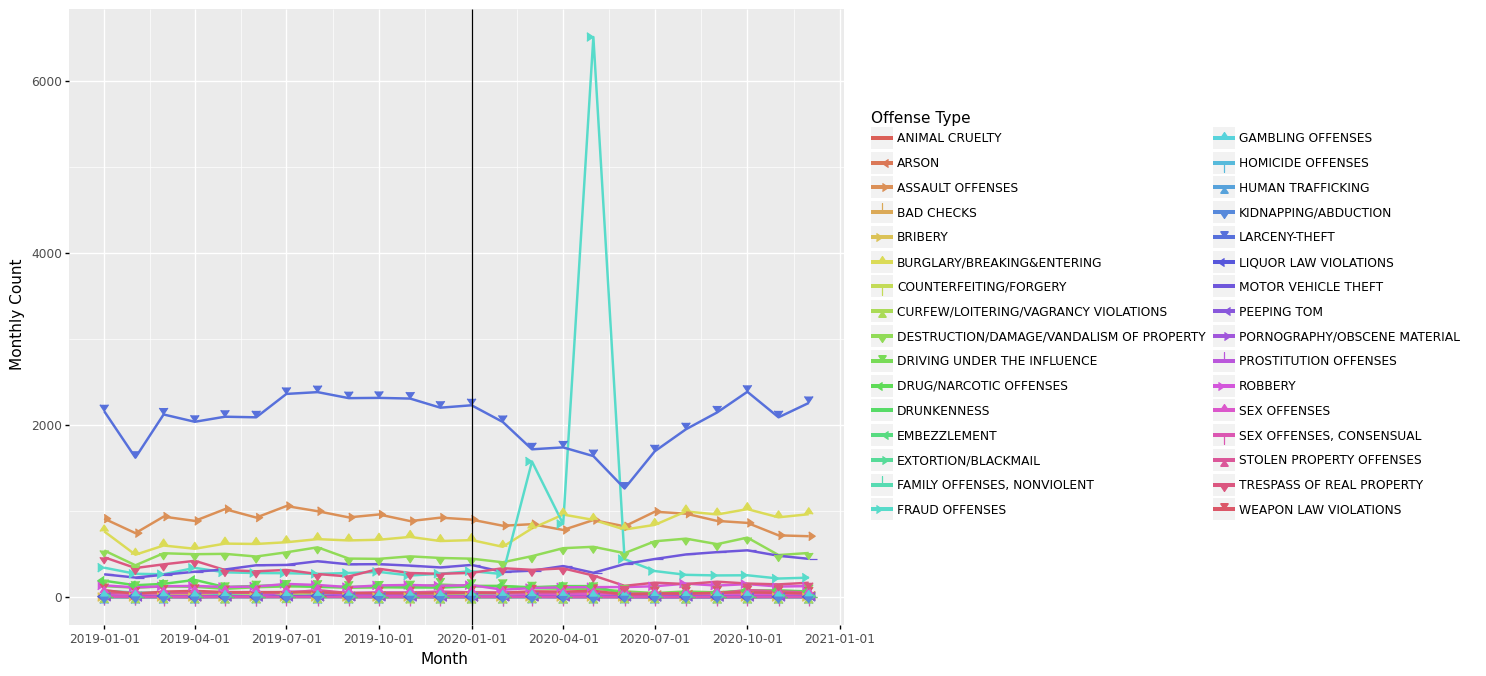

<ggplot: (8785145623751)>

In [11]:
(
    ggplot(data=COVID_offense_tally_long, mapping=aes(x='Month', y='Monthly Count', color='Offense Type')) +
    geom_line(size = 1)+
    #facet_grid('offense Type ~ .', scales = "free") +
    labs(fill="") + 
    theme(figure_size=(10, 8)) +
    geom_point(aes(shape='Offense Type', color='Offense Type'), size=3) +
    geom_vline(xintercept='2020-01-01') + 
    # Add shape variations to distinguish lines with similar colors.
    scale_shape_manual(values=[1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8, 1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8, 1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8])
)

Since readers can only easily read the trend of top **7** most frequent crimes, I will make a separate graph of other less prevalent crimes.

In [12]:
frequent_crimes = ['FRAUD OFFENSES', 'LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'MOTOR VEHICLE THEFT', 'TRESPASS OF REAL PROPERTY']
COVID_offense_tally_long_other_crimes=COVID_offense_tally_long[~COVID_offense_tally_long['Offense Type'].isin(frequent_crimes)]

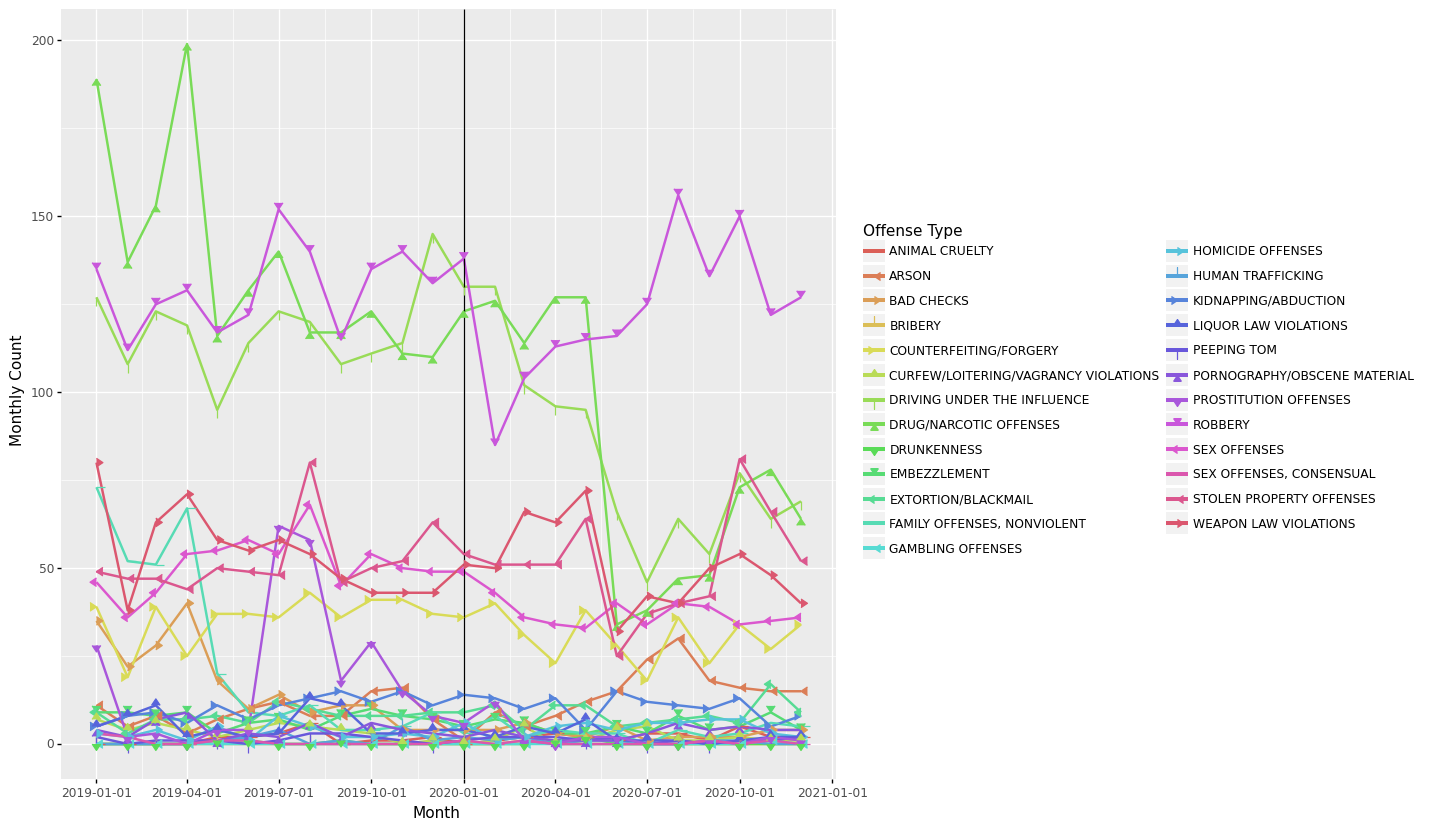

<ggplot: (8785140529848)>

In [13]:
(
    ggplot(data=COVID_offense_tally_long_other_crimes, mapping=aes(x='Month', y='Monthly Count', color='Offense Type')) +
    geom_line(size = 1)+
    labs(fill="") + 
    theme(figure_size=(10, 10)) +
    # You can make the graph longer by commenting the command above and un-comment below command, but minor crimes fluctuates with no obvious trend soon after 2020-01-01
    #theme(figure_size=(10, 50)) +
    geom_vline(xintercept='2020-01-01') + 
    geom_point(aes(shape='Offense Type', color='Offense Type'), size=3) +
    # Add shape variations to distinguish lines with similar colors.
    scale_shape_manual(values=[1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8, 1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8, 1, 4, 9, 2, 5, 10, 3, 6, 11, 7, 8])
)

### Research Question 2: compare person and property offenses

While researching the Seattle Crime overview, I found [this US News article](https://realestate.usnews.com/places/washington/seattle/crime) describing that Seattle has "a \[relatively\] lower crime rate than similarly sized metro areas"; it has a **higher rate of crimes against property** and a **lower rate of violent crimes** (against people), comparing to the national average.

For this question, I will tally the total offenses against person and property in every calendar day. By conducting a student t-test on two sets of data (property vs. person offenses daily counts), I can determine whether it's statistically significant to conclude whether crimes against person happen more frequently than crimes against property. 

In [14]:
# 5-3 only uses offense_start_date_cleaned and crime_against_category
police_data_person_property = police_data_cleaned[['offense_start_date_cleaned', 'crime_against_category']]

# Only keep rows which crime_against_category is either PERSON or PROPERTY
police_data_person_property = police_data_person_property[(police_data_person_property['crime_against_category'] == 'PERSON') | (police_data_person_property['crime_against_category'] == 'PROPERTY')]

Create a dataframe that holds the daily total of crime against property and crime against person.

In [15]:
# Create zero-filled dataframe that holds the count of each crime_against_category (from 2008-01-01 to yesterday, as today's data is not uploaded until tomorrow)
index = pd.Series(pd.date_range(datetime.strptime('2008-01', '%Y-%m'), (datetime.today()- timedelta(days=2)), freq='D'))
index = index.dt.strftime('%Y-%m-%d')

# Use unique value of crime_against_category (in police data) as column header
columns = police_data_person_property['crime_against_category'].unique()
 
person_property_offense_tally = pd.DataFrame(index=index, columns=columns)
person_property_offense_tally = person_property_offense_tally.fillna(0)

# Using code above, the data frame's index is the day; hence we need to create another month columns (whose values are year and month only)
person_property_offense_tally['Date'] = person_property_offense_tally.index
person_property_offense_tally['Date'] = person_property_offense_tally['Date'].astype('string')

Tally the number of daily crime offenses by `crime_against_category'`, and export the count to `Question 2 out.csv`.

In [16]:
# Tally number of offenses
for index, row in police_data_person_property.iterrows():
    date = row['offense_start_date_cleaned']
    one_offense = row['crime_against_category']
    date_string = date.strftime("%Y-%m-%d")
    #print(date_string + ' ' + one_offense)
    person_property_offense_tally.loc[person_property_offense_tally['Date'] == date_string, one_offense] += 1
    
move_df_col_to_first(person_property_offense_tally, 'Date')    

#print('Now printing the daily person/property offense tally')
print(person_property_offense_tally)

# Make a .csv file so end users can use a software of their choice to produce different plots.
person_property_offense_tally.to_csv('Question 2 out.csv', index=False)

                  Date  PROPERTY  PERSON
2008-01-01  2008-01-01       190      66
2008-01-02  2008-01-02       107      17
2008-01-03  2008-01-03       122      13
2008-01-04  2008-01-04       140      25
2008-01-05  2008-01-05       119      28
...                ...       ...     ...
2021-05-30  2021-05-30        62      31
2021-05-31  2021-05-31        65      30
2021-06-01  2021-06-01        26       9
2021-06-02  2021-06-02        27       3
2021-06-03  2021-06-03        37      14

[4903 rows x 3 columns]


Conduct a two-sample student-t test to verify whether it's statistically significant to conclude that Seattle has more property offense vs person offense everyday.

* Null hypothesis: Seattle's daily property offense and person offense counts are the same.

* Alternative hypothesis: Seattle's daily property offense count is greater than daily person offense count.

In [17]:
from scipy import stats

# Documentation of 2-sample t-test that I'm using: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
t_statistics, p_value = stats.ttest_ind(person_property_offense_tally['PROPERTY'], person_property_offense_tally['PERSON'], equal_var = True, alternative='greater')

print("t-statistics score is: " + str(t_statistics))
print("P value is: " + str(p_value))

t-statistics score is: 240.02101464448114
P value is: 0.0


Convert to long-format dataframe and a plot time series graph, in order to visually understand the statistic significance between daily number of two types of crime categories.

In [18]:
person_property_offense_tally_long = pd.melt(frame=person_property_offense_tally, id_vars=['Date'], var_name="Offense Category", value_name="Count")
person_property_offense_tally_long['Date']= pd.to_datetime(person_property_offense_tally_long['Date'], format='%Y-%m-%d')
#print(person_property_offense_tally_long)

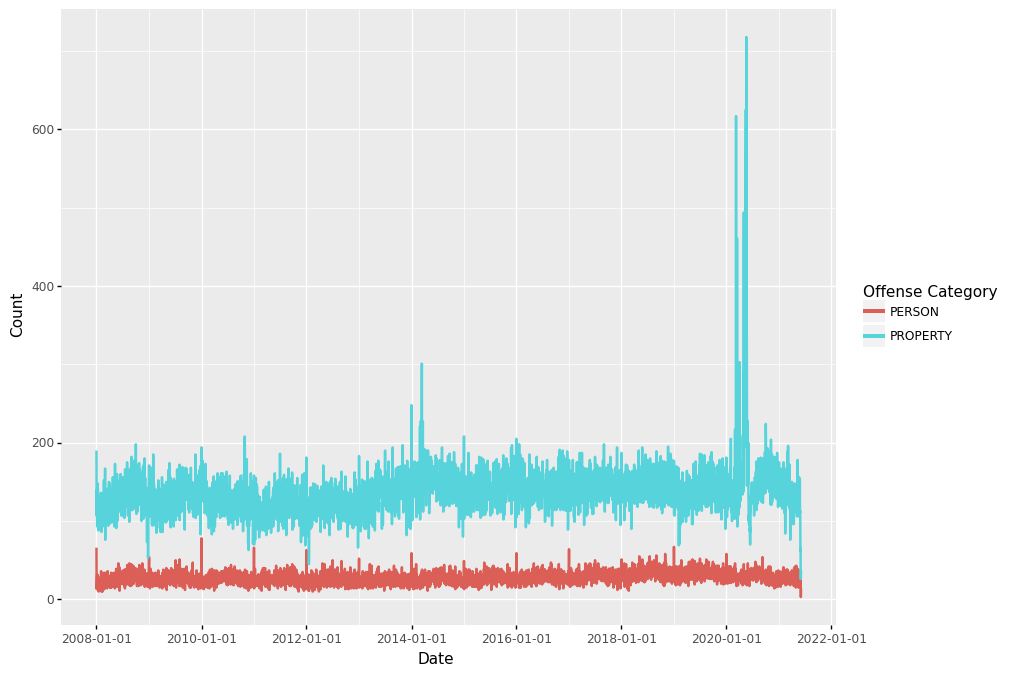

<ggplot: (8785138462422)>

In [19]:
(
    ggplot(person_property_offense_tally_long, aes(x='Date', y='Count', color='Offense Category')) +
    geom_line(size = 1)+
    labs(fill="") + 
    theme(figure_size=(10, 8))
)

### Research Question 3: find most frequent offenses in University District

After filtering the city district to University, I will tally the number of crime occurrences by `offense_parent_group` in a day, and record the most frequent type(s). Then, I will compile daily top lists together and determine which daily top crime types happen in the most number of days. To make it easier for readers to understand results, I will use a bar graph to visually it.

Note: the most frequent type(s) of offense will account for ties if there are no more than 3 ties.

More information on Seattle Police Department's Micro-Community Policing Plans (the crime dataset use this region plan to denote incident district) can be found [here](https://www.seattle.gov/police/information-and-data/mcpp-about), including geographical boundaries of each MCPP district.

Select only crime entries in the University District.

In [20]:
# Uncomment this to list all Seattle Police Department Micro-Community Policing Plan values
#print(police_data_cleaned['mcpp'].unique())

university_police_data = police_data_cleaned[police_data_cleaned['mcpp'] == 'UNIVERSITY']

# Remove crime_against_category, mcpp, and offense columns that are no longer needed for 5-3 analysis
university_police_data = university_police_data.drop(columns=['crime_against_category', 'mcpp', 'offense'])

Create a dataframe that holds daily total of crime counts in the University District.

In [21]:
# Create zero-filled dataframe that holds the count of each offense_parent_group (from 2008-01-01 to yesterday, as today's data is not uploaded until tomorrow)
index = pd.Series(pd.date_range(datetime.strptime('2008-01', '%Y-%m'), (datetime.today()- timedelta(days=2)), freq='D'))
index = index.dt.strftime('%Y-%m-%d')

# Use unique value of offense_parent_group (in police data) as column header
columns = university_police_data['offense_parent_group'].unique()
 
university_offense_tally = pd.DataFrame(index=index, columns=columns)
university_offense_tally = university_offense_tally.fillna(0)

# Using code above, the data frame's index is the day; hence we need to create another month columns (whose values are year and month only)
university_offense_tally['Date'] = university_offense_tally.index
university_offense_tally['Date'] = university_offense_tally['Date'].astype('string')

#print(university_offense_tally)

Tally the number of daily crime offenses in the University District

In [22]:
for index, row in university_police_data.iterrows():
    
    date = row['offense_start_date_cleaned']
    one_offense = row['offense_parent_group']
    date_string = date.strftime("%Y-%m-%d")
    #print(date_string + ' ' + one_offense)
    university_offense_tally.loc[university_offense_tally['Date'] == date_string, one_offense] += 1

Find top offense(s) for every calendar day. If there's a tie, record all offenses unless there are more than 3 ties.

In [23]:
# Drop Date column in original daily tally to facilitate number comparison
university_offense_tally = university_offense_tally.drop(columns=['Date'])

In [24]:
university_offense_tally_freq=[]

# Find most daily crime. If there's a tie, add everything in unless there are more than 3 ties (in this case, add nothing)
for index, row in university_offense_tally.iterrows():
    #print(row)
    highest_value = row.max()
    #print(highest_value)
    
    # Find all crime names that has the highest crime count
    most_frequent_crime = row[row==highest_value].index.tolist()
    
    # Ignore this date when we have too many ties
    if len(most_frequent_crime) <=3:
        #print(most_frequent_crime)
        university_offense_tally_freq.extend(most_frequent_crime)

Create a data frame to show frequency count for top offenses every day, and export the count to `Question 3 out.csv`.

In [25]:
import collections
freq_dictionary = dict(collections.Counter(university_offense_tally_freq))

university_offense_tally_freq_df=pd.DataFrame(list(freq_dictionary.items()), columns = ['Offense', 'Day Counts'])
print(university_offense_tally_freq_df)

# Make a .csv file so end users can use a software of their choice to produce different plots.
university_offense_tally_freq_df.to_csv('Question 3 out.csv', index=False)

                                     Offense  Day Counts
0   DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY         506
1                           ASSAULT OFFENSES         674
2                 BURGLARY/BREAKING&ENTERING         808
3                              LARCENY-THEFT        3347
4                        MOTOR VEHICLE THEFT         227
5                  TRESPASS OF REAL PROPERTY          85
6                             FRAUD OFFENSES         126
7                                    ROBBERY          67
8                     DRUG/NARCOTIC OFFENSES         102
9                      WEAPON LAW VIOLATIONS          20
10                              EMBEZZLEMENT           4
11                     LIQUOR LAW VIOLATIONS           8
12               DRIVING UNDER THE INFLUENCE          13
13                  STOLEN PROPERTY OFFENSES           3
14                                BAD CHECKS           9
15                              SEX OFFENSES           5
16                             

Select top 10 most-frequent offenses and wrap texts for offense type (text strings) to aid plotting.

In [26]:
university_offense_tally_freq_df=university_offense_tally_freq_df.nlargest(10,'Day Counts')
university_offense_tally_freq_df['Offense']=university_offense_tally_freq_df['Offense'].str.wrap(10, expand_tabs = False, replace_whitespace = True, drop_whitespace = True, break_long_words = True, break_on_hyphens = True)

Plotting most frequent offenses in the University District.

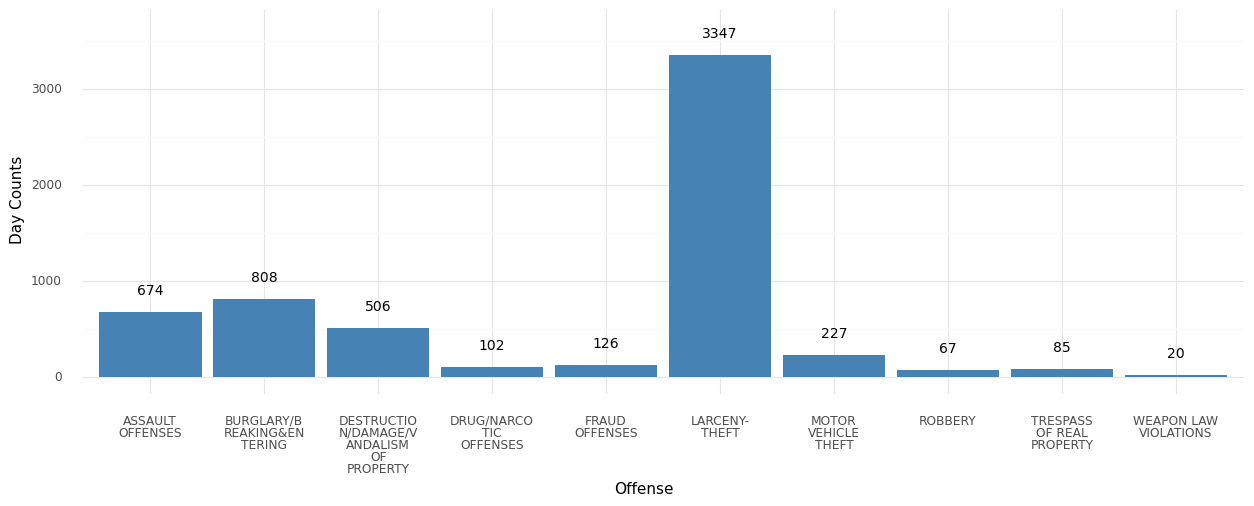

<ggplot: (8785146723485)>

In [27]:
(
    ggplot(data=university_offense_tally_freq_df, mapping=aes(x='Offense', y='Day Counts')) +
    geom_bar(stat="identity", fill="steelblue")+
    geom_text(aes(label='Day Counts'), va='top', color="black", size=10, nudge_y=300)+
    theme_minimal() + 
    theme(figure_size=(15, 5))
)

### Research Question 4: homicide counts every year
First, I will filter the entire dataset to keep only the homicide crime listings, and then tally the annual number of homicide crimes. Finally, I will make a bar chart to visually present the number of annual homicide crimes counts, where readers can visually observe whether Seattle has a record high homicide crime count in 2020.

In [28]:
# 5-5 only uses offense_start_date_cleaned and offense_parent_group (where Homicide offenses are described)
police_data_homicide = police_data_cleaned[['offense_start_date_cleaned', 'offense_parent_group']]

# Only keep rows which offense_parent_group is HOMICIDE OFFENSES
police_data_homicide = police_data_homicide[police_data_homicide['offense_parent_group'] == "HOMICIDE OFFENSES"]

Create a dataframe that holds the annual total of homicide offenses.

In [29]:
# Create zero-filled dataframe that holds the count of annual HOMICIDE OFFENSES (from 2008 to the past year)
index = pd.Series(pd.date_range(datetime.strptime('2008', '%Y'), datetime.now(), freq='Y'))
index = index.dt.strftime('%Y')

columns = ['Homicide Frequency']
annual_homicide_tally = pd.DataFrame(index=index, columns=columns)
annual_homicide_tally = annual_homicide_tally.fillna(0)

# Create a Year column so that we can tally HOMICIDE OFFENSES counts by year
annual_homicide_tally['Year'] = annual_homicide_tally.index
annual_homicide_tally['Year'] = annual_homicide_tally['Year'].astype('string')

#print(person_property_offense_tally.dtypes)
#print(annual_homicide_tally)

Tally the number of annual homicide offenses, and export the count to `Question 4 out.csv`.

In [30]:
# Tally number of homicide offenses every year
for index, row in police_data_homicide.iterrows():
    date = row['offense_start_date_cleaned']
    year_string = date.strftime("%Y")
    #print(date_string + ' ' + one_offense)
    annual_homicide_tally.loc[annual_homicide_tally['Year'] == year_string, 'Homicide Frequency'] += 1
    
move_df_col_to_first(annual_homicide_tally, 'Year')   
    
#print('Now printing the daily homicide offense tally')
print(annual_homicide_tally)

# Make a .csv file so end users can use a software of their choice to produce different plots.
annual_homicide_tally.to_csv('Question 4 out.csv', index=False)

      Year  Homicide Frequency
2008  2008                  30
2009  2009                  21
2010  2010                  19
2011  2011                  24
2012  2012                  24
2013  2013                  26
2014  2014                  28
2015  2015                  28
2016  2016                  21
2017  2017                  30
2018  2018                  34
2019  2019                  38
2020  2020                  55


Plot annual homicide offense frequency bar graph.

Please note: the current year is not included in the frequency bar graph, as historical data encompasses all 12-months of data, while the current year data is less than 12 months.

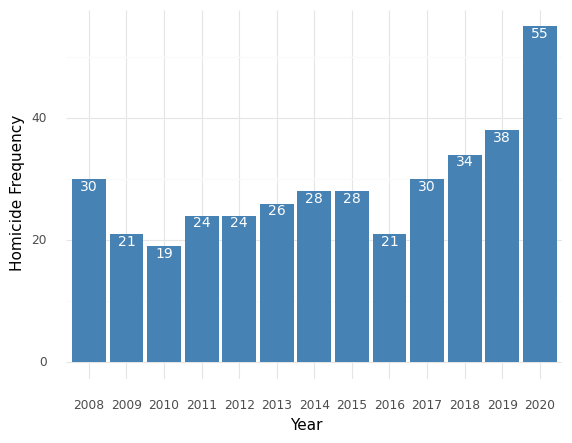

<ggplot: (8785145621866)>

In [31]:
(
    ggplot(data=annual_homicide_tally, mapping=aes(x='Year', y='Homicide Frequency')) +
    geom_bar(stat="identity", fill="steelblue")+
    geom_text(aes(label='Homicide Frequency'), va='top', color="white", size=10)+
    theme_minimal()
)

## 6: Findings and Results

* Research Question 1: **Fraud offense** (large increase), burglary, vandalism of property, robbery, and weapon law violation have increased after 2020-01-01
* Research Question 2: Crime against property is noticeably more frequent than crime against person (t-statistics: 241. ; p-value: 0.0)
* Research Question 3: Larceny/theft, burglary, and assault offenses are popular in the University District
* Research Question 4: Seattle do have a record-high homicide offense in 2020 (55 offenses total)


## 7: Discussion

### Question 1:

Initially, I hypothesized that personal assault crimes would increase after 2020-01-01, but the Seattle crime dataset shows that the number of monthly assault offenses does not change.

There was a record-high 6513 fraud offenses in May, 2020; the number is much larger than any other offenses at any time. Observing the sharp increase of fraud offense after 2020-01-01, the time when COVID-19 Pandemic had become evident in the US, I remembered how scammers attempts to file fake unemployment benefit claims using other people's identity, according to a newsletter in the UW Information School mailing list. While researching more news articles that analyzes this situation, I discovered [a Deloitte article](https://www2.deloitte.com/ch/en/pages/financial-advisory/articles/covid-19-operating-in-the-new-normal-fraud-risk.html) describing the US economic depression, the increased unemployment rate, and the lack of information security during companies' transition to remote working all provide excellent opportunities for perpetrators to commit fraud schemes. 

Political events, such as George Floyd's death and subsequent violent protests, contribute to other property-destruction related offenses after 2020-01-01, and people's financial instability due to job loss might encourage them to commit property thefts, resulting a higher overall crime offenses. 

### Question 2:

It is statistically significant to conclude that (in most calendar days) total crimes against property outnumbered crimes against person, which confirms [this US News article's analysis](https://realestate.usnews.com/places/washington/seattle/crime) on Seattle crime distribution. The original crime dataset categorize fraud, bribery and several offenses that are loosely related to robbery/theft as crimes against property. Some readers (including me) consider crimes against property as robbery-related offenses that damages/steals civilians' personal properties.

### Question 3:

Data analysis confirms with my hypothesis that larceny/robbery crimes happen most frequently in the University District (there are 3346 days having highest number of larceny/robbery offense counts), and this offense type outnumbers other offenses.

### Question 4:

Analyzing original dataset regarding Seattle's annual homicide counts reveals that Seattle **do** have a record-high homicide count in 2020, which confirms with [King5 news article's](https://www.king5.com/article/news/local/seattle-police-reports-49-murders-setting-pace-for-record-homicides/281-c32aa4ae-ef9c-485f-a9d8-1113b491fc9d) claim. 

### Ethical consideration

* Crime classification is subjective, and one person may categorize a crime differently than another person.
* Crime offenses that are subsequently acquitted may not be removed from this dataset, resulting in a higher number of crime entries than actual prosecutable offenses.
* Civil right activists may question Seattle Police Department's biased policing against people with color, although I could not find firm evidences that support this claim.

### Unknown and dependencies:

* The Seattle Crime dataset may not contain all crimes that actually happened in the city. The website stated that only finalized (UCR approved) reports are published in this dataset. Those in draft, awaiting approval, or completed after the update may be published at a later date.
* When crime investigation proceeds further, crime entries may be retroactively added, updated, or removed, which may result in change of historical data when readers re-run my Jupyter notebook program at a later date.
* This dataset does not include committed crimes that are not yet discovered/found out by any police department.
* Many crimes are reported after crime offenses, and the offense date & time may not be accurate.
* University District covers a larger area than the UW itself (even though this district is very related to the UW community), and some readers may disagree with this geographical scope set by Seattle Police Department.

## 8: Conclusion

Analyzing the Seattle Crime Dataset (from Seattle Police Department) informed me the overall distribution of crime activities in Seattle and University of Washington. Additionally, findings from this analysis project makes me more vigilant on protecting my property while going out to different locations in Seattle (especially when I am walking on the street in unfamiliar locations). Result from this data analysis encourages readers to take extra care on their properties while in Seattle, and especially be vigilant on fraud attempts. Moreover, these findings helps people in the University of Washington area to aware thefts on their laptop computers and other valuable items. Finally, observing a record-high homicide offense counts in 2020 encouraged me to consider possible causes of this social issue. 